In [1]:
import os
import sys
import shutil

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from copy import deepcopy

In [3]:
from BuildingOccupancy import Person, Meeting, BuildingOccupancyAsMatrix, BuildingOccupancy
import DefaultBuildings
from Agents import agent_constructor
#from CentralController import ddpg_episode_mc
import RLCritics
import StateUtilities as SU
from Options import get_argparser
from ReplayBuffer import ReplayBufferStd

Documentation: https://cobs-platform.github.io/

In [4]:
args = get_argparser().parse_args([
        "--algorithm", "ddqn",
        "--idf_file",  "",
        "--epw_file",  os.path.abspath("../../COBS/cobs/data/weathers/8.epw"),
        "--checkpoint_dir", "/tmp",
        "--shared_network_per_agent_class",
        "--number_occupants", "40",
        "--ts_per_hour", "1",
        "--episode_start_month", "1"
    ])

Helper functions

In [26]:
year      = 2017
month     = args.episode_start_month
start_day = datetime.date(year, month, 1)
while start_day.weekday() > 0:
    start_day += datetime.timedelta(days=1)
start_day = start_day.day
start_dto = datetime.datetime(year, month, start_day)
dto       = datetime.datetime(year, month, start_day)
dto_lst   = []

time_resolution = datetime.timedelta(minutes = 60 // args.ts_per_hour)
while (dto - start_dto).days < 7:
    #dto_lst.append(dto.strftime("%a.\n%H:%M"))
    dto_lst.append(dto.strftime("%a. %H:%M"))
    dto += time_resolution

In [28]:
def yticks_rooms(yt):
    yt([0,1,2,3,4], [f"SPACE {i}" for i in range(1,6)])
def xticks_time(xt, xlim):
    positions, _ = xt()
    limits = xlim()
    labels = []
    for pos in positions:
        if pos >= 0 and pos < len(dto_lst):
            labels.append(dto_lst[int(pos)])
        else:
            labels.append("")
    xt(positions, labels, rotation=-45, ha="left")
    #xt(positions, labels)
    xlim(limits)
def xticks_time_more_labels(xt, xlim, min_pos, max_pos, n_labels):
    positions = np.linspace(min_pos, max_pos, n_labels)
    limits = xlim()
    labels = []
    for pos in positions:
        if pos >= 0 and pos < len(dto_lst):
            labels.append(dto_lst[int(pos)])
        else:
            labels.append("")
    xt(positions, labels, rotation=-45, ha="left")
    #xt(positions, labels)
    xlim(limits)

<h3>Define the model</h3>

In [7]:
cobs.Model.set_energyplus_folder(global_paths["eplus"])

In [8]:
building = DefaultBuildings.Building_5ZoneAirCooled_SingleSetpoint(args)

In [9]:
building_occ = BuildingOccupancyAsMatrix(args, building)

In [10]:
building_occ.schedule_table.shape

(168, 31, 5)

Text(0, 0.5, 'Occupant ID')

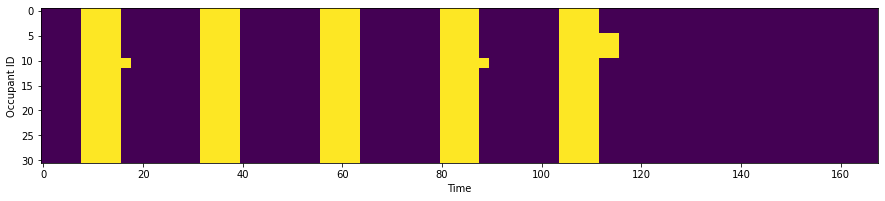

In [11]:
plt.figure(figsize=(15,8))
plt.imshow(building_occ.schedule_table.sum(axis=2).T)
plt.xlabel("Time")
plt.ylabel("Occupant ID")
#plt.colorbar()
# occupancy per person

Text(0, 0.5, 'Room ID')

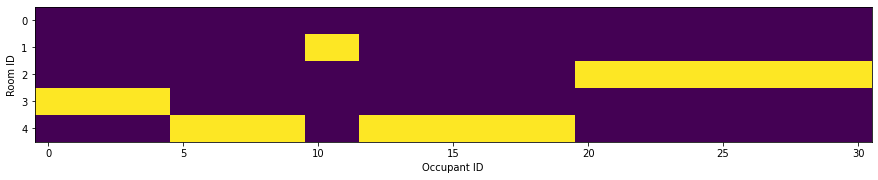

In [12]:
plt.figure(figsize=(15,8))
plt.imshow(building_occ.schedule_table[10].T)
plt.xlabel("Occupant ID")
plt.ylabel("Room ID")
# occupancy at time step 10 (rooms on y, persons on x)

In [13]:
people_in_rooms = building_occ.schedule_table[10].sum(axis=0)
people_in_rooms.clip(min=1)

array([ 1.,  2., 11.,  5., 13.])

In [14]:
building_occ.schedule_table.sum(axis=1).max(axis=0)

array([ 4.,  5., 11.,  5., 20.])

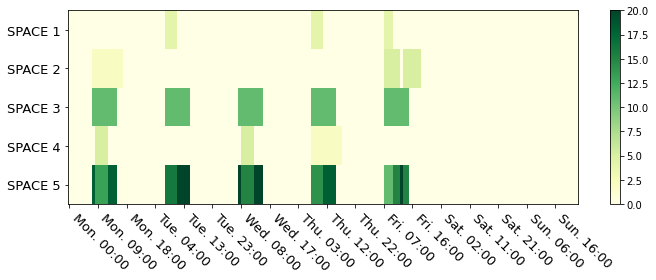

In [48]:
# occupancy per room
plt.figure(figsize=(10,4))
plt.imshow(building_occ.schedule_table.sum(axis=1).T, aspect="auto", cmap="YlGn")#cmap='jet') #YlOrRd
yticks_rooms(plt.yticks)
#xticks_time(plt.xticks, plt.xlim)
xticks_time_more_labels(plt.xticks, plt.xlim, 0, 160, 18)
plt.xlabel("")
plt.ylabel("")
plt.colorbar()#extend='both', shrink=0.95)
a = plt.gca()
for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                 a.get_xticklabels() + a.get_yticklabels()):
    item.set_fontsize(13)
plt.tight_layout()
#plt.savefig("saved_plots/Occupancy_Matrix_pdf.pdf")
#plt.savefig("saved_plots/Occupancy_Matrix_png.png")

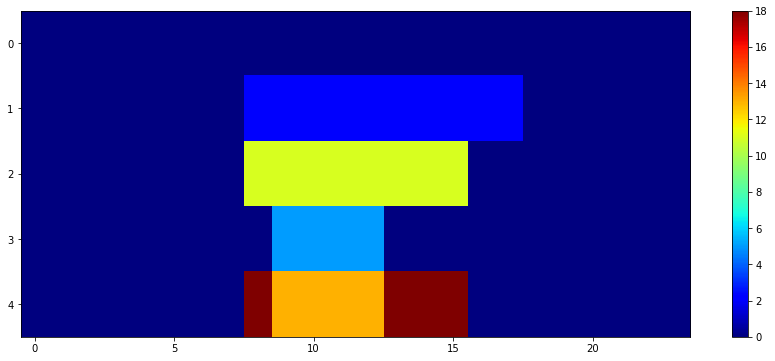

In [49]:
# occupancy per room
# ONLY ON MONDAY
plt.figure(figsize=(15,6))
plt.imshow(building_occ.schedule_table[0:24,:,:].sum(axis=1).T, aspect="auto", cmap='jet')
plt.colorbar()

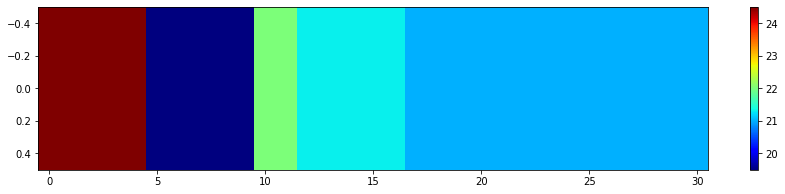

In [50]:
plt.figure(figsize=(15,3))
plt.imshow(building_occ.occupants[:,np.newaxis].T, aspect="auto", cmap='jet')
plt.colorbar()

In [51]:
building_occ.manual_setpoint_changes(datetime.datetime(2017,1,2,10,15), {room:15 for room in building.room_names}, None)

(31.0,
 28.03846153846154,
 {'SPACE2-1': 22.0,
  'SPACE3-1': 21.0,
  'SPACE4-1': 24.5,
  'SPACE5-1': 20.53846153846154})